##General Code

In [206]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pysentani

In [207]:
survey = pd.read_excel('../data-clean/sentani-merged-cleaned-2015-06-10.xlsx',na_values=[''])
print('number of entries =', len(survey))
print('number of columns =', len(survey.columns))

number of entries = 1184
number of columns = 274


In [208]:
pysentani.similar_columns(survey,'HP')

HP_y_n
HP
HP_charging_source
HP_charging_price
HP_charging_frequency
HP_quantity


In [209]:
survey['electricity_expenditure_monthly'] = pysentani.elec_expenditure_monthly(survey)
survey['electricity_expenditure_monthly_log'] = survey['electricity_expenditure_monthly'].dropna().replace(0, 1)
survey['electricity_expenditure_monthly_log'] = np.log10(survey['electricity_expenditure_monthly_log'])
survey['income_monthly'] = pysentani.income_monthly(survey)
survey['access_type'] = pysentani.access_type(survey)
survey['income_monthly'] = survey['income_monthly'].replace(0, 1)
survey['income_monthly_log'] = np.log10(survey['income_monthly'])

In [210]:
hh_series = pd.value_counts(household_survey['village_name'])
hh_ls = list(hh_series)


pd.crosstab(household_survey['power_supply/private_genset'],household_survey['power_supply_working/private_genset'])
go_df = household_survey.groupby(['village_name'])[['power_supply_working/private_genset']].agg(['count'])
access_dict = household_survey.set_index('village_name')['access_type'].to_dict()
access_ls = list(access_dict.values())
village_ls = list(access_dict.keys())

#type(go_df['power_supply_working/private_genset'])
go_series = go_df['power_supply_working/private_genset']['count']

percentage_ownership_series = (go_series/hh_series)*100
po_dict = {'households': hh_ls, 'access_type':access_ls,'village':village_ls}
po_df = pd.DataFrame(po_dict)
po_df

def elec_access(df):
    if df['access_type'] == 'no_access':
        access = "No Access"
    else:
        access = "Access"
    
    return access

po_df['access'] = po_df.apply(elec_access, axis = 1)
household_survey['access'] = household_survey.apply(elec_access, axis = 1)
po_df

ownership_survey = pd.DataFrame.from_dict(data = po_df.groupby('access')['households'].sum().to_dict(), orient ='index')

In [211]:
app_series1 = ['app_buy/rice_cooker','app_buy/fridge','app_buy/fan','app_buy/radio','app_buy/TV','app_buy/lighting']


pao_ls = []

for aps in app_series1:
    
    app_now = 'app_now' + aps[7:]  
    
    temp_app_now_df = pd.crosstab(household_survey['access'],household_survey[app_now])
    temp_app_buy_df = pd.crosstab(household_survey[household_survey[app_now] == False]['access'],household_survey[aps])
    
    ownership_df = pd.DataFrame.from_dict(data = temp_app_now_df[1.0].to_dict(), orient ='index')
    column_name_own = 'households_own_' + aps[8:]
    ownership_survey[column_name_own] = ownership_df[0]
    
    desire_df = pd.DataFrame.from_dict(data = temp_app_buy_df[1.0].to_dict(), orient ='index')
    column_name_want = 'households_want_' + aps[8:]
    ownership_survey[column_name_want] = desire_df[0]

ownership_survey['access'] = list(ownership_survey.index)

In [212]:
if 0 in list(ownership_survey.columns):
    ownership_survey.rename(columns={0:'total_households'}, inplace=True)

In [213]:
app_series2 = ['rice_cooker','fridge','fan','radio','lighting','TV']
access_series = ['No Access','Access']

na_ownership_survey = ownership_survey[ownership_survey['access'] == 'No Access']
a_ownership_survey = ownership_survey[ownership_survey['access'] == 'Access']

na_dict = {}
a_dict = {}

df_ls = []

for aps in app_series2:
    
    own = 'households_own_' + aps
    want = 'households_want_' + aps
    app_key = 'projected_ownership_' + aps
    
    projected_po_na = (((na_ownership_survey[own] + na_ownership_survey[want])/na_ownership_survey['total_households']) * 100)['No Access']
    
    existing_po_a = ((a_ownership_survey[own] / a_ownership_survey['total_households']) * 100)['Access']
    
    for acs in access_series:
        if acs == 'No Access':
            na_dict.update({'access':'No Access', app_key: projected_po_na})
        else:
            a_dict.update({'access': 'Access', app_key: existing_po_a})

            
df_ls.append(na_dict)
df_ls.append(a_dict)
df = pd.DataFrame(df_ls)  

In [214]:
ppo_df = pd.melt(df, id_vars=['access'], value_vars=['projected_ownership_fan','projected_ownership_fridge','projected_ownership_radio','projected_ownership_rice_cooker','projected_ownership_lighting','projected_ownership_TV'])

(0, 100)

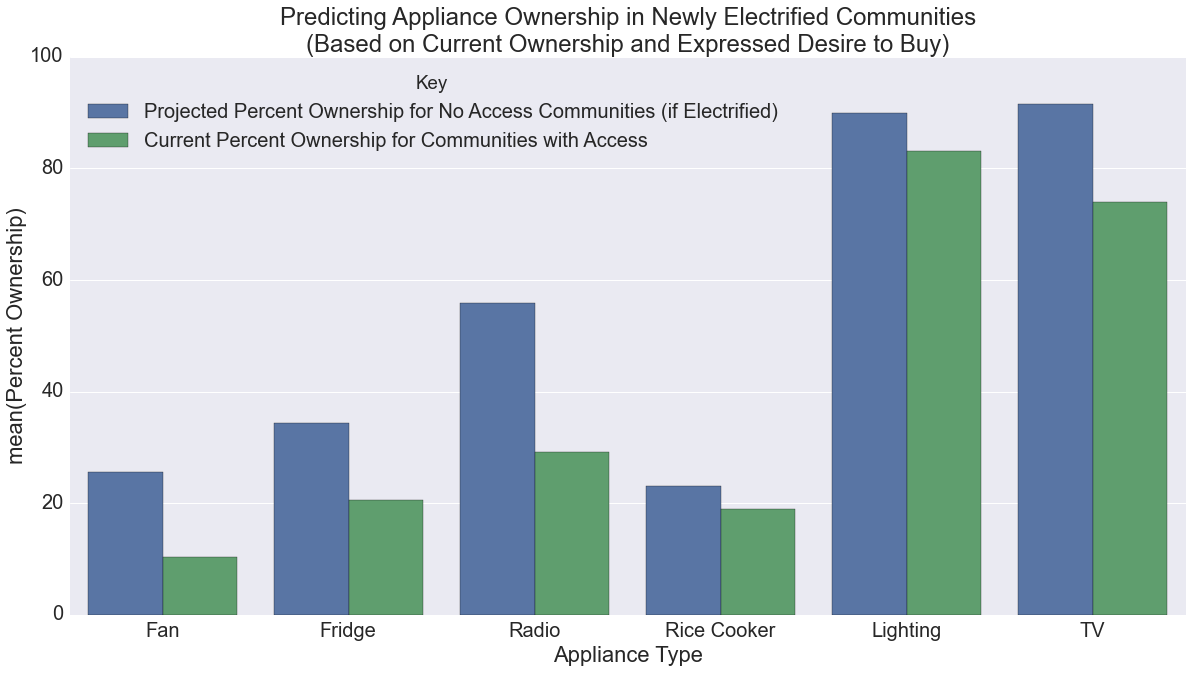

In [227]:
ppo_df.replace(to_replace = {'variable': {'projected_ownership_fan': 'Fan',
                                          'projected_ownership_fridge': 'Fridge',
                                          'projected_ownership_radio': 'Radio',
                                          'projected_ownership_rice_cooker': 'Rice Cooker',
                                          'projected_ownership_lighting': 'Lighting',
                                          'projected_ownership_TV': 'TV'},
                             'access': {'No Access': 'Projected Percent Ownership for No Access Communities (if Electrified)',
                                        'Access': 'Current Percent Ownership for Communities with Access' }},
                                        inplace = True)

ppo_df.rename(columns={'variable': 'Appliance',
                       'value': 'Percent Ownership',
                       'access': 'Key'},
                       inplace = True)

sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x="Appliance", y="Percent Ownership", hue="Key", data=ppo_df)


ax.set(xlabel='Appliance Type',title = 'Predicting Appliance Ownership in Newly Electrified Communities\n(Based on Current Ownership and Expressed Desire to Buy)')

plt.ylim(0,100)

#fig.savefig('test.pdf')

In [222]:
ppo_df

,Key,Appliance,Percent Ownership
0,Projected Percent Ownership for No Access Comm...,Fan,25.506073
1,Current Percent Ownership for Communities with...,Fan,10.442260
2,Projected Percent Ownership for No Access Comm...,Fridge,34.412955
3,Current Percent Ownership for Communities with...,Fridge,20.638821
4,Projected Percent Ownership for No Access Comm...,Radio,55.870445
5,Current Percent Ownership for Communities with...,Radio,29.115479
6,Projected Percent Ownership for No Access Comm...,Rice Cooker,23.076923
7,Current Percent Ownership for Communities with...,Rice Cooker,19.041769
8,Projected Percent Ownership for No Access Comm...,Lighting,89.878543
9,Current Percent Ownership for Communities with...,Lighting,83.046683
